
# Wstęp

## Cel ćwiczenia

Celem ćwiczenia jest **wytrenowanie od podstaw sieci typu MLP (Multi-Layer Perceptron)** oraz **analiza wpływu wybranych dobrych praktyk** stosowanych w deep learningu na proces uczenia i jakość uzyskiwanych wyników.
W trakcie zadania będziemy świadomie podejmować decyzje projektowe dotyczące architektury, przygotowania danych oraz procesu treningu.


# Ogólne informacje do zadania

### 1. Zbiór danych

W zadaniu wykorzystany zostanie zbiór **FashionMNIST**, który jest dostępny domyślnie w bibliotece `torchvision`.

Przy pierwszym uruchomieniu notebooka zbiór danych zostanie pobrany na dysk lokalny.
W tym celu należy ustawić flagę `download=True` oraz wskazać odpowiednią ścieżkę w parametrze `root`.

> **Uwaga:**
> W przypadku korzystania z Google Colab zaleca się podłączenie Google Drive, aby uniknąć ponownego pobierania danych przy każdym uruchomieniu środowiska.

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```

Zbiór FashionMNIST służy do **klasyfikacji obrazów należących do 10 różnych klas odpowiadającym elementom garderoby** (np. koszulka, płaszcz, but itp).
Nie jest to zbiór przesadnie trudny, natomiast jego plusem jest szybki czas przetwarzania.

### UWAGA
Jeśli ktoś chciałby mieć większe wyzwanie to polecam przeprowadzić rozwiązania na zbiorze [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvisiondatasets.CIFAR10.html), który nie jest już tak trywialnym zbiorem (dalej ma obrazki i 10 klas, natomiast klasyfikacja jest trudniejsza oraz czas przetwarzania, będzie większy). Jest on również dostępny w `torchvision.datasets` przez co pobiera go się go w analogiczny sposób co MNIST





### 2. Trenowanie sieci MLP

Celem zadania jest wykorzystanie zdobytej wiedzy z zakresu implementacji modeli w **PyTorch** lub **PyTorch Lightning** do wytrenowania sieci składającej się z kilku warstw liniowych (stąd nazwa **Multi-Layer Perceptron**).

Model będzie używany do klasyfikacji obrazów, mimo że:

* dla danych obrazowych **znacznie lepiej sprawdzają się sieci konwolucyjne (CNN)**,
* MLP nie wykorzystuje informacji o strukturze przestrzennej obrazu.

Świadomie ograniczamy się tutaj do MLP, ponieważ:

* pozwala to skupić się na **uniwersalnych dobrych praktykach**, które będą opisane poniżej:
* ułatwia zrozumienie **dlaczego i w jaki sposób CNN przewyższają MLP** w zadaniach wizji komputerowej.

Dopiero po zaobserwowaniu ograniczeń klasycznej sieci MLP możliwe jest pełne docenienie zalet architektur konwolucyjnych, które zostaną omówione w kolejnych zadaniach.

W ramach teorii potrzebnej do zrozumienia na czym polega uczenie sieci MLP, bardzo mocno polecam pierwsze 4 rozdziały z playlist [Neural Networks 3Blue 1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), która w świetny sposób tłumaczy to zagadnienie. Dodatkowo jeśli ktoś nie czuje się do końca dobrze z algorytmem propagacji wstecznej, to również polecam obejrzeć.




### 3. Wykorzystanie dobrych praktyk w trakcie uczenia modelu

W poprzedniej liście zadań trenowaliście **pojedynczy perceptron**, który można uznać za bardzo prostą sieć neuronową.
Proces uczenia polegał głównie na doborze podstawowych hiperparametrów, takich jak:

* liczba epok,
* współczynnik uczenia (*learning rate*).

Dodatkowo wykorzystywany był **zbiór walidacyjny**, który pozwalał obserwować wartość funkcji straty na danych niewidzianych przez model w trakcie uczenia.
Jest to kluczowy element oceny zdolności modelu do **generalizacji**, czyli sprawdzenia, czy model nie uczy się na pamięć danych treningowych (*overfitting*).

W praktycznych zastosowaniach deep learningu stosuje się jednak **szereg dodatkowych technik**, które:

* stabilizują proces uczenia,
* poprawiają generalizację,
* ułatwiają analizę i debugowanie modeli.

W ramach tego zadania będziecie musieli **zrozumieć wszystkie poniższe techniki** oraz przebadać wpływ części z nich na proces uczenia.

---

#### 3.1 Monitorowanie `val_loss` i zapisywanie najlepszego modelu

Podczas treningu wartość straty na zbiorze walidacyjnym (`val_loss`) **nie zawsze maleje monotonicznie**.
Często model osiąga najlepsze wyniki na danych walidacyjnych w pewnej epoce, po czym zaczyna się przeuczać.

Dlatego:

* w trakcie uczenia monitorujemy `val_loss`,
* zapisujemy parametry modelu z epoki, w której `val_loss` było **najniższe**,
* po zakończeniu treningu **ładujemy najlepszy zapisany model**, a nie ten z ostatniej epoki.

**Dlaczego to robimy?**

* minimalizujemy ryzyko overfittingu,
* wykorzystujemy model o najlepszej zdolności generalizacji,
* wynik końcowy nie zależy od arbitralnie dobranej liczby epok.

Technika ta jest często realizowana poprzez tzw. *checkpointing*.

---

#### 3.2 Early stopping

**Early stopping** to mechanizm, który **automatycznie przerywa trening**, jeśli jakość modelu na zbiorze walidacyjnym przestaje się poprawiać.

Działanie:

* obserwujemy `val_loss`,
* jeśli przez określoną liczbę epok (*patience*) nie nastąpi poprawa,
* trening zostaje zakończony.

**Dlaczego to robimy?**

* zapobiegamy przeuczeniu modelu,
* skracamy czas treningu,
* oszczędzamy zasoby obliczeniowe.

Early stopping jest szczególnie skuteczny w połączeniu z **zapisywaniem najlepszego modelu**, ponieważ zapewnia, że końcowy model pochodzi z najlepszego momentu treningu.

**Materiały**
- [Early stopping](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)

---

#### 3.3 Logowanie metryk i funkcji straty

W trakcie treningu należy logować:

* wartość funkcji straty (`loss`),
* metryki jakości (np. accuracy),
* zarówno dla zbioru treningowego, jak i walidacyjnego.

Logowanie może odbywać się:

* do **TensorBoarda**,
* lub w formie danych umożliwiających późniejsze narysowanie wykresów.

**Dlaczego to robimy?**

* umożliwia to wizualną analizę procesu uczenia,
* pozwala szybko wykryć problemy (np. overfitting, zbyt duży learning rate, niestabilne uczenie),
* ułatwia porównywanie różnych eksperymentów i konfiguracji modelu.

W praktyce logowanie jest jednym z podstawowych narzędzi pracy z modelami deep learningowymi.

---

#### 3.4 Regularizacja (L1, L2, Dropout)

Regularizacja ma na celu **ograniczenie nadmiernej złożoności modelu**, co poprawia jego zdolność generalizacji.

* **L1 (Lasso):**

  * dodaje do funkcji straty sumę wartości bezwzględnych wag:

$$
\begin{aligned}
 \lambda \sum_{i} |w_i|
\end{aligned}
$$


  * sprzyja rzadkim rozwiązaniom (wiele wag przyjmuje wartości bliskie zeru).

* **L2 (Ridge / weight decay):**

  * dodaje do funkcji straty sumę kwadratów wag:
$$
\begin{aligned}
    \lambda \sum_{i} w_i^2
\end{aligned}
$$

  * zapobiega nadmiernemu wzrostowi wag,

  * jest najczęściej stosowaną formą regularizacji w deep learningu.

* **Dropout:**

  * w trakcie treningu losowo „wyłącza” część neuronów,
  * zmusza sieć do uczenia się bardziej odpornych reprezentacji,
  * działa jak uśrednianie wielu modeli.

**Dlaczego to robimy?**

* zmniejszamy overfitting,
* poprawiamy stabilność uczenia,
* model lepiej generalizuje na nowe dane.

> **Uwaga:** regularizacja to hiperparametr – jej siłę należy dobrać eksperymentalnie.
> Zbyt silna regularizacja może prowadzić do *underfittingu*.

**Materiały pomocniczne**

* [regularyzacja L1 i L2](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
* [dropout](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575)

---

#### 3.5 Harmonogram uczenia – Cosine Learning Rate Scheduling

Zamiast używać stałego learning rate, często stosuje się **harmonogram jego zmiany w czasie**.

**LR scheduling (np. Cosine Scheduling):**

* learning rate zmniejsza się zgodnie z krzywą cosinusa,
* na początku uczenie jest agresywne,
* pod koniec staje się bardzo delikatne.

Intuicyjnie:

* duży learning rate pomaga szybko znaleźć dobry obszar rozwiązań,
* mały learning rate pozwala dokładnie „dostroić” wagi.

**Dlaczego to robimy?**

* poprawiamy stabilność uczenia,
* często osiągamy lepsze minima funkcji straty,
* zmniejszamy potrzebę ręcznego doboru learning rate.

> W praktyce harmonogram uczenia często ma **większy wpływ na wynik końcowy** niż niewielkie zmiany architektury.

**Materiały**

* [cosine scheduling](https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541)

---

#### 3.6 Batch Normalization

**Batch Normalization (BatchNorm)** to technika polegająca na **normalizacji aktywacji w warstwach sieci neuronowej** w trakcie treningu.

Dla każdej cechy w mini-batchu:

* odejmowana jest średnia,
* dzielone jest przez odchylenie standardowe,
* a następnie stosowane są uczone parametry skali i przesunięcia.

Intuicyjnie:

* dane „wewnątrz sieci” mają stabilniejszy rozkład,
* kolejne warstwy dostają lepiej uwarunkowane wejście.

**Dlaczego to robimy?**

* stabilizujemy i przyspieszamy proces uczenia,
* umożliwiamy stosowanie większego learning rate,
* zmniejszamy wrażliwość modelu na inicjalizację wag,
* często poprawiamy generalizację (BatchNorm działa częściowo jak regularizacja).

**Ważne uwagi praktyczne:**

* BatchNorm **zachowuje się inaczej w trakcie treningu i inferencji**
  (używa statystyk batcha vs. statystyk zebranych podczas treningu).
* Nie zawsze jest konieczna- w małych sieciach lub przy bardzo małych batchach może **nie przynieść korzyści**.
* BatchNorm **nie jest zamiennikiem regularizacji** (np. Dropoutu), choć czasem może zmniejszyć jej potrzebę.

**Matariały**
- [Batch Normalization](https://medium.com/@piyushkashyap045/understanding-batch-normalization-in-deep-learning-a-beginners-guide-40917c5bebc8)

**UWAGA**
W praktyce nie dodajemy Batch Normalization „w ciemno” do każdej warstwy. Przy części problemów może ona okazać się bardzo pomocna i są pewne architektury które bez niej sobie nie są w stanie poradzić, ale dla prostych problemów jej wpływ może nie być wcale duży. Warto natomiast w każdym przypadku być świadomym, że coś takiego istnieje, ponieważ jest to techina bardzo szeroko stosowana.


# 4. Elementy architektury i treningu, o których należy pamiętać

Poza dobrymi praktykami związanymi z procesem uczenia (takimi jak early stopping, regularizacja czy harmonogram learning rate), istnieją również **podstawowe decyzje projektowe**, które są **ściśle związane z architekturą sieci oraz sposobem jej trenowania**.

Elementy te często mają **istotny wpływ na zbieżność uczenia, stabilność gradientów oraz końcową jakość modelu**, dlatego warto mieć ich istnienie na uwadze — nawet jeśli w tym zadaniu nie będą one głównym obiektem badań.

W szczególności należą do nich:

---

#### 4.1 Funkcje aktywacji

Funkcja aktywacji określa, w jaki sposób sygnał wyjściowy neuronu jest przekształcany i przekazywany do kolejnych warstw.
W praktyce deep learningu najczęściej spotyka się następujące, **bazowe funkcje aktywacji**:

* **Sigmoid**
  Historycznie bardzo popularna, obecnie rzadziej stosowana w warstwach ukrytych ze względu na problem zanikającego gradientu.

* **Tanh**
  Podobna do sigmoidy, ale o wyjściu symetrycznym względem zera; również może prowadzić do problemów z gradientami w głębokich sieciach.

* **ReLU (Rectified Linear Unit)**
  Najczęściej stosowana funkcja aktywacji w nowoczesnych sieciach neuronowych; prosta i skuteczna, sprzyja stabilnemu uczeniu.

Wybór funkcji aktywacji wpływa na dynamikę uczenia i może znacząco zmienić zachowanie modelu, nawet przy tej samej architekturze.


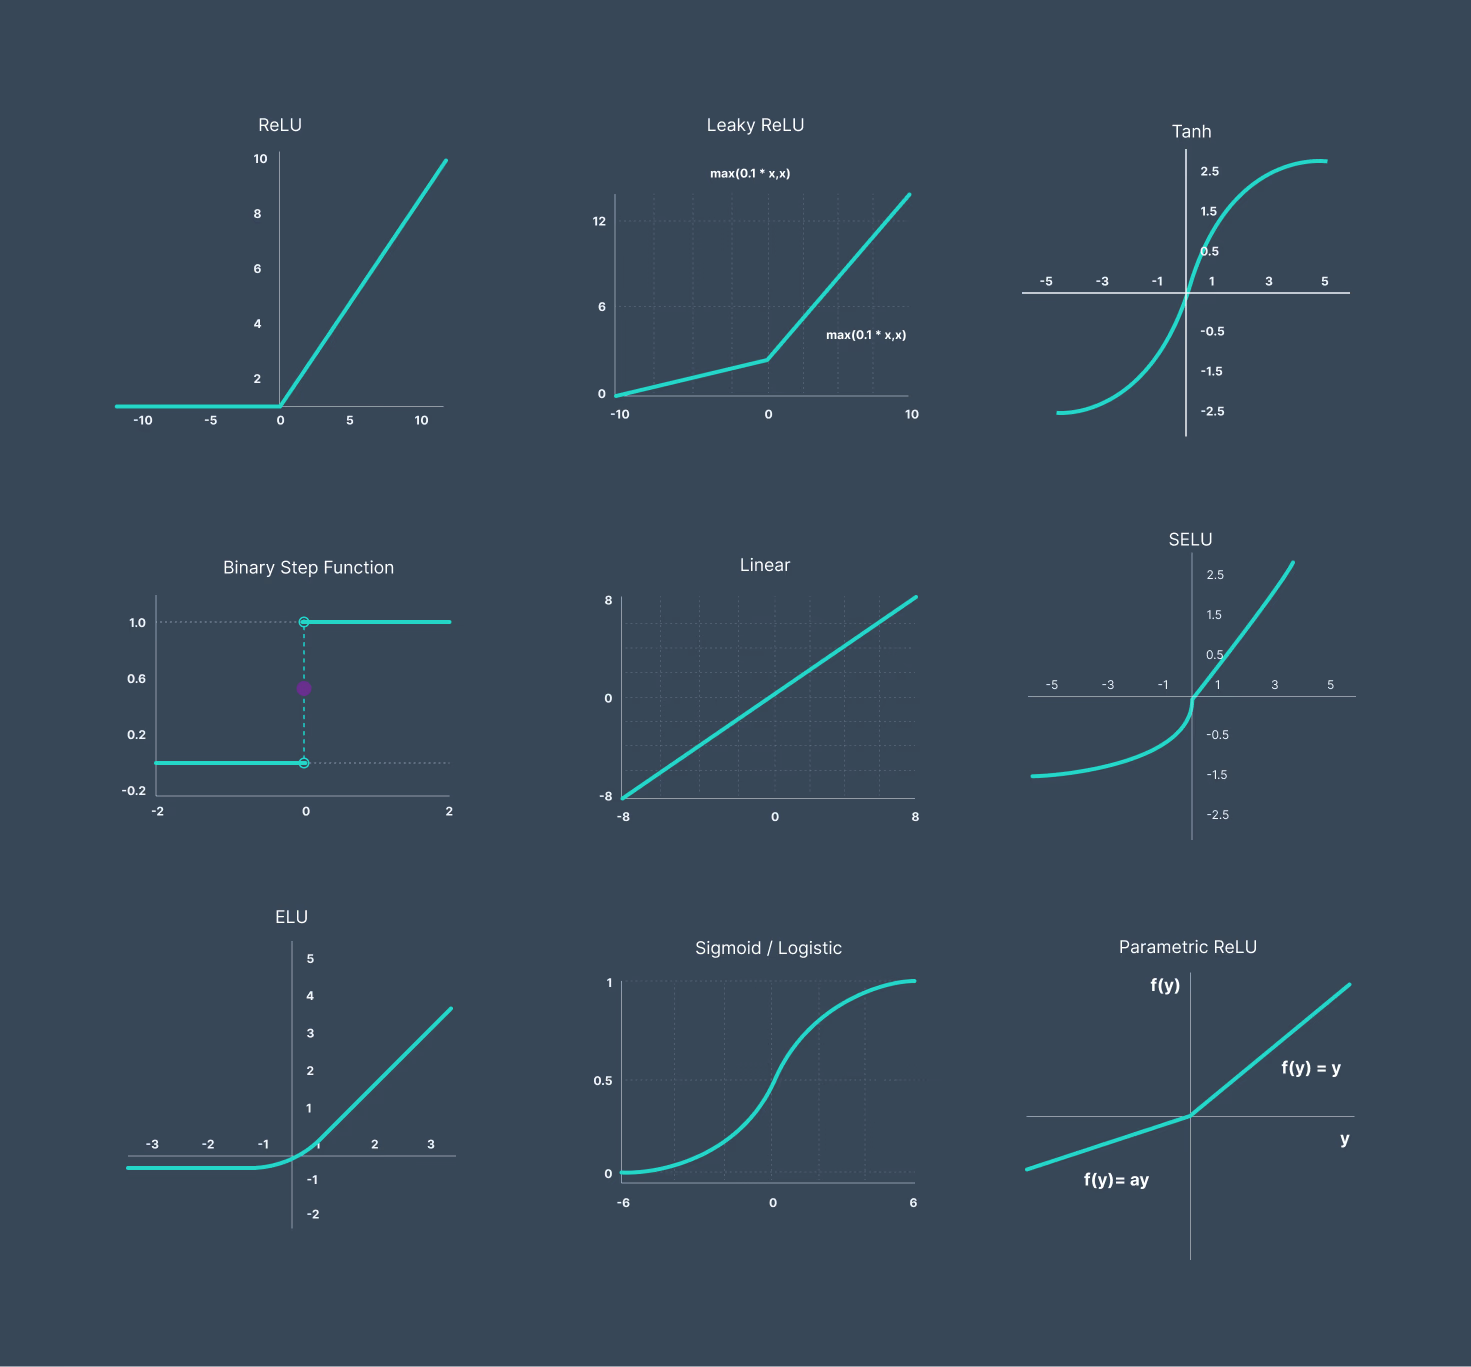


---

#### 4.2 Optymalizatory

Optymalizator określa, **w jaki sposób aktualizowane są wagi modelu** na podstawie obliczonych gradientów funkcji straty.

Do najczęściej stosowanych optymalizatorów należą:

* **SGD (Stochastic Gradient Descent)**
  Klasyczna metoda oparta bezpośrednio na gradiencie; często wymaga starannego doboru learning rate i dodatkowych technik (np. momentum).

* **[Adam](https://www.geeksforgeeks.org/deep-learning/adam-optimizer/)**
  Adaptacyjny optymalizator, który automatycznie dostosowuje learning rate dla poszczególnych parametrów; bardzo popularny ze względu na dobrą stabilność i szybkie zbieganie.


Wybór optymalizatora ma wpływ na szybkość uczenia, stabilność treningu oraz jakość znalezionego minimum funkcji straty. W praktyce wybór Adama jest zawsze dobrym wyborem i ciężko znaleźć kod który wybiera inny optymalizator. Kluczowe jednak jest wiedzieć, że tak jak większość optymalizatorów, mocno bazuje na SGD, dlatego warto być świadomym również jak działa ten klasyczny algorytm.
Z mniej znanych metod o których warto wspomnieć są [AdaGrad](https://www.geeksforgeeks.org/machine-learning/intuition-behind-adagrad-optimizer/), [RMSProp](https://medium.com/@piyushkashyap045/understanding-rmsprop-a-simple-guide-to-one-of-deep-learnings-powerful-optimizers-403baeed9922)





# KROKI DO WYKONANIA ZADANIA

W ramach zadania jesteście proszeni o wykonanie następujących kroków:

### 1. Przygotowanie danych

* Załadujcie zbiór danych i **zwizualizujcie kilka przykładowych obserwacji** (np. rozmiar obrazów, liczba kanałów, czy są kolorowe czy w skali szarości).
* Utwórzcie **DataLoadery** dla zbiorów *train*, *validation* oraz *test*, które będą zwracały dane w formacie odpowiednim dla modelu.
* Na potrzeby tego zadania **augmentacja danych nie jest wymagana**.

---

### 2. Definicja modelu

* Przygotujcie klasę `ParameterizedMLP`, która będzie definiowała architekturę sieci neuronowej.
* Klasa powinna być **sparametryzowana**, tak aby możliwe było sterowanie architekturą modelu poprzez przekazywane argumenty, w szczególności:

  * liczba warstw ukrytych oraz liczba neuronów w każdej z nich,
  * użycie Batch Normalization (wystarczy flaga typu `bool`).

---

### 3. Kod treningowy

* Napiszcie kod umożliwiający trening modelu, **obowiązkowo korzystając z PyTorcha lub frameworka PyTorch Lightning**.
* Kod powinien umożliwiać:

  * logowanie wartości funkcji straty oraz metryk jakości dla zbiorów *train* i *validation* w każdej epoce,
  * ustawienie parametru `patience`, kontrolującego działanie mechanizmu *early stopping*,
  * ewaluację modelu na zbiorze testowym po zakończeniu treningu,
  * zapisanie **najlepszego modelu** (na podstawie wyników walidacyjnych).
* Proces treningu musi być **zdeterminowany (seedowany)**, tak aby możliwe było rzetelne porównywanie wyników pomiędzy eksperymentami.

---

### 4. Eksperymenty

Na przygotowanym kodzie należy przeprowadzić **kilka eksperymentów**, których celem jest zbadanie wpływu wybranych technik na proces uczenia modelu.

W szczególności powinny się pojawić następujące eksperymenty:

* **Early stopping**
  Porównanie przebiegu krzywych uczenia w przypadku:

  * treningu bez early stoppingu,
  * treningu z włączonym early stoppingiem.

* **Architektura sieci**
  Eksperymenty z różnymi architekturami sieci. Dowolność jak chcecie do tego podejść. Ja polecam dla dodania ciekawości zadania sprawdzić:
  * bardzo małą architetę
  * dużą architekturę
  * i jakąś pomiędzy którą uznamy za optymalną

* **Regularizacja**
  Porównanie uczenia:

  * z regularizacją L1 lub L2 vs. bez regularizacji,
  * z Dropoutem vs. bez Dropoutu.

* **Scheduling learning rate**
  Eksperyment pokazujący wpływ harmonogramu zmiany learning rate.
  W tym przypadku warto również **logować wartość learning rate w kolejnych epokach**.

* **Batch Normalization**
  Porównanie modelu:

  * z Batch Normalization,
  * bez Batch Normalization.

* **Optymalizator**
  Porównanie algorytmu optyalizującego wagi:
  * Adam (jako najczęściej stosowany w praktyce)
  * SGD (klasyczna metoda)

---

## UWAGI

* Nie jest wymagane przeprowadzanie rozbudowanego *grid searcha* ani badanie wszystkich możliwych kombinacji technik.
  Wystarczy podejście inkrementalne:

  * trenujecie **bazowy model** (prosta architektura, bez regularizacji, bez schedulingu learning rate, bez early stoppingu, itd),
  * następnie w kolejnych eksperymentach **zmieniacie tylko jeden czynnik naraz** (np. dodajecie early stopping, zwiększacie liczbę warstw, włączacie scheduler itp.) i obserwujecie jego wpływ na wyniki.

* Z tego powodu **wszystkie eksperymenty powinny być wykonywane na tym samym seedzie oraz tym samym podziale danych** (ten sam split train/val/test), aby porównania były miarodajne.

* Warto zadbać o to, aby kod był **czytelny, modularny i dobrze zorganizowany**.
  W kolejnych zadaniach będziecie pracować z modelami konwolucyjnymi — dobrze napisany kod treningowy będzie można w dużej mierze ponownie wykorzystać.
* W tym zadaniu nie jest wymagane systematyczne porównywanie wszystkich funkcji aktywacji (chodź nie jest zakazane), należy natomiast wybrać jedną i uwzględnić ją w implementacji modelu.


#Przygotowanie danych


In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets
from google.colab import drive # remove the cell if not using colab
from pathlib import Path
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import copy
from sklearn.metrics import accuracy_score
import torch.optim as optim

In [2]:

drive.mount('/content/drive')
base_path = Path('/content/drive/MyDrive/FashionMINST') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.FashionMNIST(
    root=base_path,
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root=base_path,
    train=False,
    download=True,
    transform=transform
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Zobaczymy co tam wgl jest

In [3]:
trainset.classes
train_counts = trainset.targets.bincount()
test_counts = testset.targets.bincount()


for i, name in enumerate(trainset.classes):
    print(name, train_counts[i].item(), test_counts[i].item())

T-shirt/top 6000 1000
Trouser 6000 1000
Pullover 6000 1000
Dress 6000 1000
Coat 6000 1000
Sandal 6000 1000
Shirt 6000 1000
Sneaker 6000 1000
Bag 6000 1000
Ankle boot 6000 1000


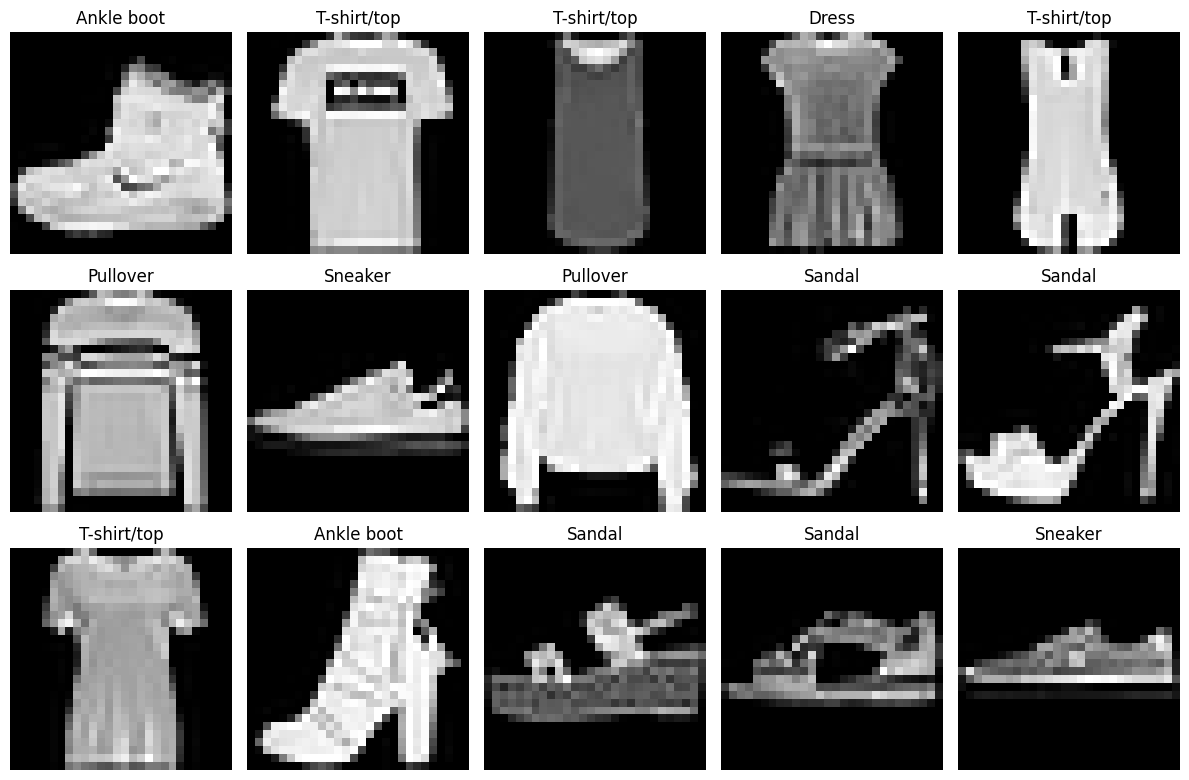

In [4]:
plt.figure(figsize=(12, 8))

for i in range(15):
    img, label_idx = trainset[i]
    img_to_show = img.permute(1, 2, 0)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img_to_show, cmap='gray')
    plt.title(trainset.classes[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
BATCH_SIZE = 128
SEED = 67

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

generator = torch.Generator().manual_seed(SEED)
train_data, val_data = random_split(trainset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader =   DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader =  DataLoader(testset,    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


#Definicja modelu


Uzywam w tej liscie reLu bo bardziej pasuje do potrzeb - klasyfikacja

In [6]:
class ParameterizedMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, use_batch_norm=False, dropout=0.0):

        super().__init__()



        current_input_dim = input_size

        for hidden_dim in hidden_sizes:
            layers.append(nn.Linear(current_input_dim, hidden_dim))

            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            layers.append(nn.ReLU())
            current_input_dim = hidden_dim

            if dropout > 0:
              layers.append(nn.Dropout(p=dropout))

        layers.append(nn.Linear(current_input_dim, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#Kod treningowy


In [7]:
def run_experiment(
    hidden_sizes=[256, 128],
    dropout=0.0,
    batch_norm=True,
    optimizer_cls=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    scheduler_cls=None,
    scheduler_params={},
    patience=5,
    epochs=10,
    name="exp"
):

    model = ParameterizedMLP(
        input_size=28*28,
        hidden_sizes=hidden_sizes,
        output_size=10,
        use_batch_norm=batch_norm,
        dropout=dropout
    )

    optimizer = optimizer_cls(model.parameters(), **optimizer_params)

    trainer = Trainer(model, optimizer, torch.nn.CrossEntropyLoss(), scheduler=scheduler, patience=patience)
    trainer.train(train_loader, val_loader, n_epochs=epochs, save_path=f"{name}.pth")
    trainer.plot_history() # Rysuje wykresy od razu po treningu

    return trainer.evaluate_test(test_loader)

In [8]:
class Trainer:
    def __init__(self, model, optimizer, criterion, scheduler=None, patience=5):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.patience = patience

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def train(self, train_loader, val_loader, n_epochs, save_path="best_model.pth"):

        best_loss = float('inf')
        best_model_wts = copy.deepcopy(self.model.state_dict())
        early_stop_counter = 0

        for epoch in range(n_epochs):

            start_time = time.time()
            self.model.train()
            train_loss = 0.0
            train_preds = []
            train_targets = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)

                train_preds.extend(preds.cpu().numpy())
                train_targets.extend(labels.cpu().numpy())

            epoch_train_loss = train_loss / len(train_loader.dataset)
            epoch_train_acc = accuracy_score(train_targets, train_preds)

            self.model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)

                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())

            epoch_val_loss = val_loss / len(val_loader.dataset)
            epoch_val_acc = accuracy_score(val_targets, val_preds)

            self.history['train_loss'].append(epoch_train_loss)
            self.history['val_loss'].append(epoch_val_loss)
            self.history['train_acc'].append(epoch_train_acc)
            self.history['val_acc'].append(epoch_val_acc)

            if self.scheduler:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(epoch_val_loss)
                else:
                    self.scheduler.step()
                current_lr = self.optimizer.param_groups[0]['lr']
            else:
                current_lr = self.optimizer.param_groups[0]['lr']

            print(f"Epoka {epoch+1}/{n_epochs} (LR: {current_lr:.5f}) | "
                  f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
                  f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

            #early dtoping
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_model_wts = copy.deepcopy(self.model.state_dict())
                torch.save(self.model.state_dict(), save_path) # Zapis fizyczny na dysk
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= self.patience:
                    print(f"\nEarly Stopping! Brak poprawy od {self.patience} epok.")
                    break

        self.model.load_state_dict(best_model_wts)
        print("\nTrening zakończony. Najlepszy model załadowany.")
        return self.history

    def evaluate_test(self, test_loader):
        self.model.eval()
        preds = []
        targets = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                preds.extend(predicted.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        acc = accuracy_score(targets, preds)
        return acc

    def plot_history(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Val Loss', linestyle='--')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Acc')
        plt.plot(self.history['val_acc'], label='Val Acc', linestyle='--')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.show()

#Eksperymenty


Z zadania:

W szczególności powinny się pojawić następujące eksperymenty:

* **Early stopping**
  Porównanie przebiegu krzywych uczenia w przypadku:

  * treningu bez early stoppingu,
  * treningu z włączonym early stoppingiem.

* **Architektura sieci**
  Eksperymenty z różnymi architekturami sieci. Dowolność jak chcecie do tego podejść. Ja polecam dla dodania ciekawości zadania sprawdzić:
  * bardzo małą architetę
  * dużą architekturę
  * i jakąś pomiędzy którą uznamy za optymalną

* **Regularizacja**
  Porównanie uczenia:

  * z regularizacją L1 lub L2 vs. bez regularizacji,
  * z Dropoutem vs. bez Dropoutu.

* **Scheduling learning rate**
  Eksperyment pokazujący wpływ harmonogramu zmiany learning rate.
  W tym przypadku warto również **logować wartość learning rate w kolejnych epokach**.

* **Batch Normalization**
  Porównanie modelu:

  * z Batch Normalization,
  * bez Batch Normalization.

* **Optymalizator**
  Porównanie algorytmu optyalizującego wagi:
  * Adam (jako najczęściej stosowany w praktyce)
  * SGD (klasyczna metoda)


Epoka 1/10 (LR: 0.00100) | Train Loss: 0.5771 Acc: 0.8266 | Val Loss: 0.4212 Acc: 0.8450
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.3531 Acc: 0.8720 | Val Loss: 0.3769 Acc: 0.8682
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3138 Acc: 0.8840 | Val Loss: 0.3455 Acc: 0.8734
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.2861 Acc: 0.8948 | Val Loss: 0.3378 Acc: 0.8765
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.2650 Acc: 0.9018 | Val Loss: 0.3224 Acc: 0.8844
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.2480 Acc: 0.9080 | Val Loss: 0.3511 Acc: 0.8772
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2349 Acc: 0.9116 | Val Loss: 0.3166 Acc: 0.8878
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2197 Acc: 0.9192 | Val Loss: 0.3576 Acc: 0.8799
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2079 Acc: 0.9224 | Val Loss: 0.3256 Acc: 0.8863
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2001 Acc: 0.9245 | Val Loss: 0.3672 Acc: 0.8753

Trening zakończony. Najlepszy model załadowany.


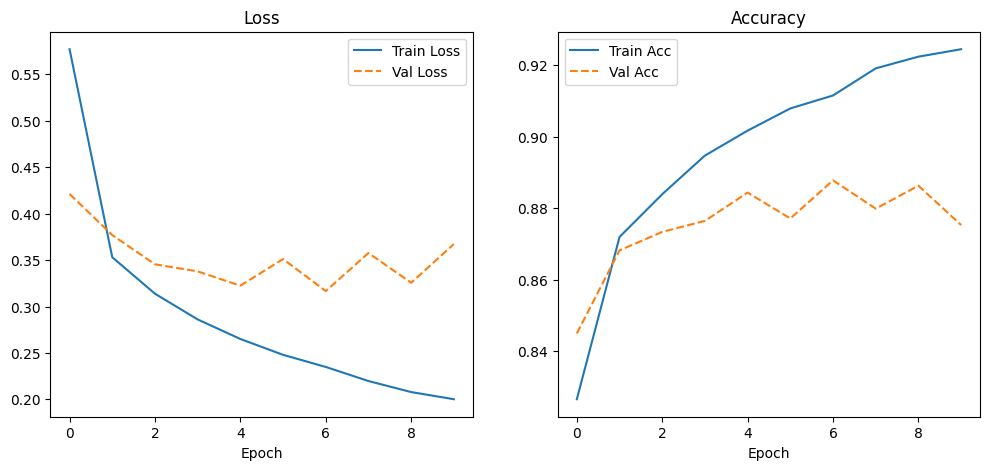

0_BezEarlyStopping wynik: 88.34%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.5815 Acc: 0.8275 | Val Loss: 0.3974 Acc: 0.8584
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.3552 Acc: 0.8729 | Val Loss: 0.3694 Acc: 0.8678
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3166 Acc: 0.8825 | Val Loss: 0.3304 Acc: 0.8813
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.2878 Acc: 0.8936 | Val Loss: 0.3381 Acc: 0.8787
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.2679 Acc: 0.8994 | Val Loss: 0.3382 Acc: 0.8791
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.2495 Acc: 0.9079 | Val Loss: 0.3221 Acc: 0.8832
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2338 Acc: 0.9146 | Val Loss: 0.3213 Acc: 0.8844
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2204 Acc: 0.9181 | Val Loss: 0.3220 Acc: 0.8908
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2111 Acc: 0.9220 | Val Loss: 0.3299 Acc: 0.8808
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2002 Acc: 0.9258 | Val Loss: 0.3305 Acc: 0.8855

Trening zakończony. Najlepszy model załadowany.


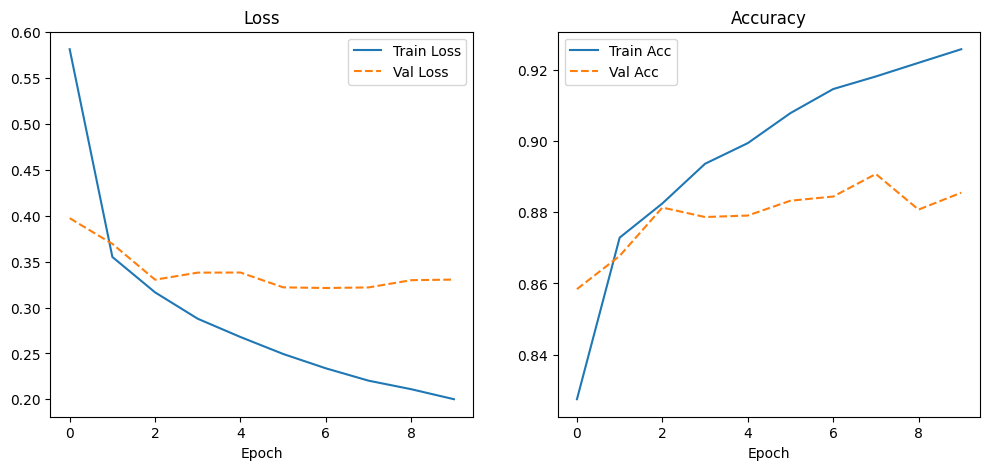

earlyStopping wynik: 87.63%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.7287 Acc: 0.8040 | Val Loss: 0.4588 Acc: 0.8405
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.3874 Acc: 0.8650 | Val Loss: 0.4231 Acc: 0.8512
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3400 Acc: 0.8789 | Val Loss: 0.3657 Acc: 0.8688
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.3145 Acc: 0.8849 | Val Loss: 0.3627 Acc: 0.8720
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.2946 Acc: 0.8919 | Val Loss: 0.3452 Acc: 0.8758
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.2806 Acc: 0.8968 | Val Loss: 0.3601 Acc: 0.8709
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2647 Acc: 0.9037 | Val Loss: 0.3330 Acc: 0.8840
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2581 Acc: 0.9058 | Val Loss: 0.3404 Acc: 0.8803
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2465 Acc: 0.9088 | Val Loss: 0.3420 Acc: 0.8812
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2384 Acc: 0.9120 | Val Loss: 0.3381 Acc: 0.8810

Trening zakończony. Najlepszy model załadowany.


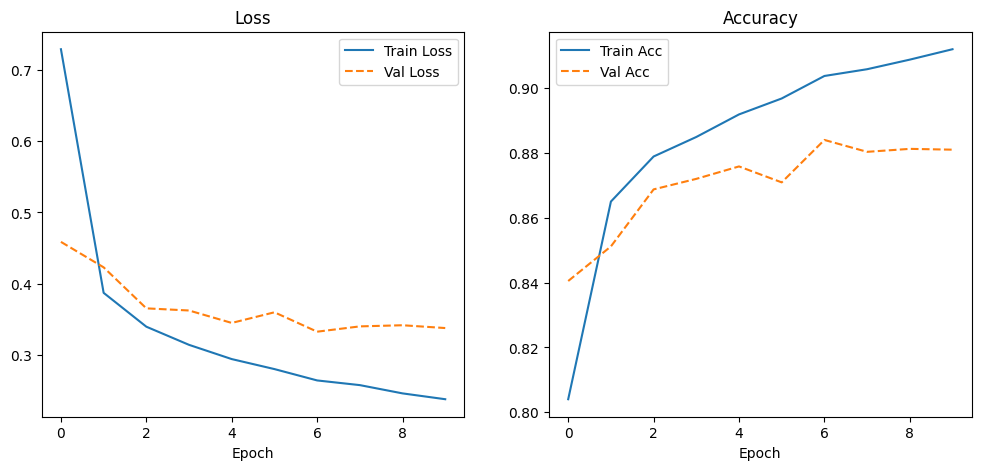

MalaArchitektura wynik: 87.51%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.7039 Acc: 0.8257 | Val Loss: 0.4198 Acc: 0.8578
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.3718 Acc: 0.8714 | Val Loss: 0.3676 Acc: 0.8706
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3258 Acc: 0.8817 | Val Loss: 0.3333 Acc: 0.8808
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.2954 Acc: 0.8931 | Val Loss: 0.3410 Acc: 0.8767
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.2744 Acc: 0.9006 | Val Loss: 0.3233 Acc: 0.8844
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.2576 Acc: 0.9047 | Val Loss: 0.3351 Acc: 0.8812
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2426 Acc: 0.9111 | Val Loss: 0.3221 Acc: 0.8848
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2281 Acc: 0.9166 | Val Loss: 0.3290 Acc: 0.8838
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2154 Acc: 0.9202 | Val Loss: 0.3333 Acc: 0.8834
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2052 Acc: 0.9230 | Val Loss: 0.3540 Acc: 0.8782

Trening zakończony. Najlepszy model załadowany.


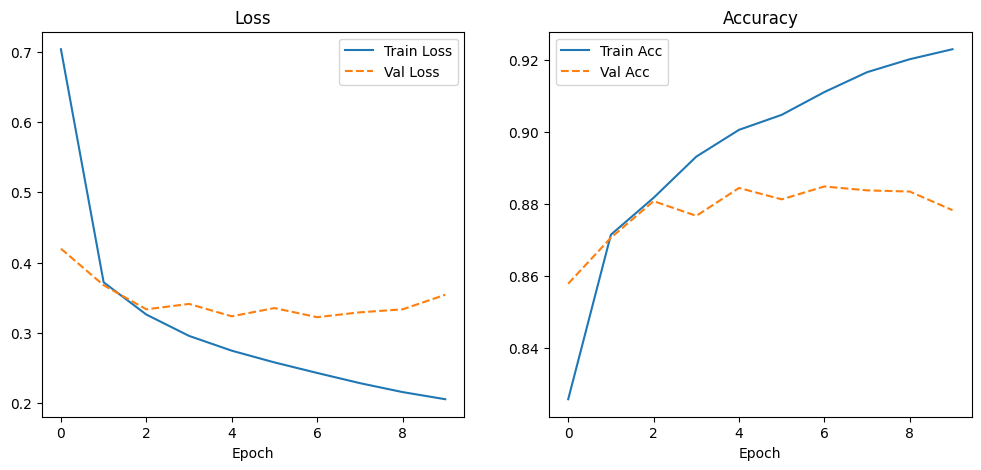

DuzaArchitektura wynik: 87.85%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.5667 Acc: 0.8272 | Val Loss: 0.4067 Acc: 0.8545
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.3546 Acc: 0.8732 | Val Loss: 0.3894 Acc: 0.8615
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3140 Acc: 0.8846 | Val Loss: 0.3351 Acc: 0.8788
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.2892 Acc: 0.8922 | Val Loss: 0.3312 Acc: 0.8813
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.2693 Acc: 0.9001 | Val Loss: 0.3179 Acc: 0.8876
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.2527 Acc: 0.9077 | Val Loss: 0.3242 Acc: 0.8836
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2386 Acc: 0.9120 | Val Loss: 0.3506 Acc: 0.8768
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2253 Acc: 0.9164 | Val Loss: 0.3438 Acc: 0.8794
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2182 Acc: 0.9177 | Val Loss: 0.3333 Acc: 0.8856
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2038 Acc: 0.9245 | Val Loss: 0.3239 Acc: 0.8898

Early Stopping! Brak poprawy od 5 epok.

Trening zakończony. Najlepszy model 

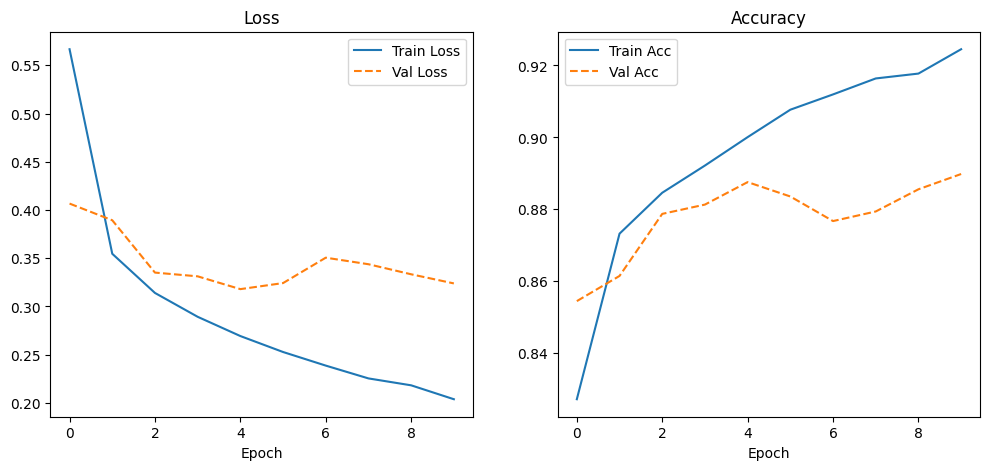

RegularizacjaL2 wynik: 88.09%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.5952 Acc: 0.7893 | Val Loss: 0.4550 Acc: 0.8370
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.4167 Acc: 0.8482 | Val Loss: 0.4052 Acc: 0.8558
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.3755 Acc: 0.8614 | Val Loss: 0.3776 Acc: 0.8665
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.3458 Acc: 0.8730 | Val Loss: 0.3630 Acc: 0.8711
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.3293 Acc: 0.8783 | Val Loss: 0.3702 Acc: 0.8630
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.3084 Acc: 0.8846 | Val Loss: 0.3365 Acc: 0.8782
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.2939 Acc: 0.8904 | Val Loss: 0.3471 Acc: 0.8752
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.2820 Acc: 0.8946 | Val Loss: 0.3257 Acc: 0.8847
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.2695 Acc: 0.8993 | Val Loss: 0.3347 Acc: 0.8803
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.2590 Acc: 0.9026 | Val Loss: 0.3366 Acc: 0.8798

Trening zakończony. Najlepszy model załadowany.


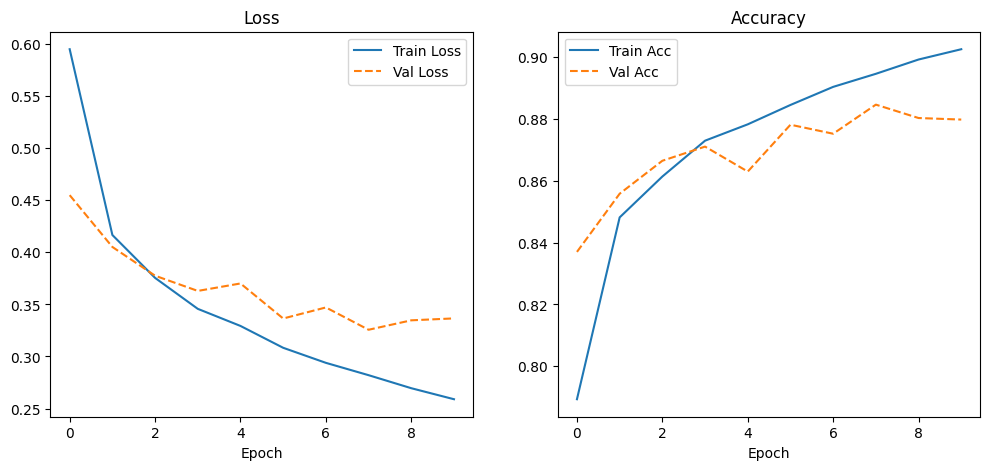

BatchNorm wynik: 87.48%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.7202 Acc: 0.7867 | Val Loss: 0.4444 Acc: 0.8439
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.4548 Acc: 0.8414 | Val Loss: 0.3833 Acc: 0.8597
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.4151 Acc: 0.8533 | Val Loss: 0.3615 Acc: 0.8712
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.3898 Acc: 0.8618 | Val Loss: 0.3519 Acc: 0.8738
Epoka 5/10 (LR: 0.00100) | Train Loss: 0.3716 Acc: 0.8673 | Val Loss: 0.3461 Acc: 0.8734
Epoka 6/10 (LR: 0.00100) | Train Loss: 0.3569 Acc: 0.8720 | Val Loss: 0.3402 Acc: 0.8763
Epoka 7/10 (LR: 0.00100) | Train Loss: 0.3448 Acc: 0.8768 | Val Loss: 0.3232 Acc: 0.8856
Epoka 8/10 (LR: 0.00100) | Train Loss: 0.3338 Acc: 0.8787 | Val Loss: 0.3259 Acc: 0.8819
Epoka 9/10 (LR: 0.00100) | Train Loss: 0.3245 Acc: 0.8817 | Val Loss: 0.3313 Acc: 0.8799
Epoka 10/10 (LR: 0.00100) | Train Loss: 0.3178 Acc: 0.8845 | Val Loss: 0.3257 Acc: 0.8832

Trening zakończony. Najlepszy model załadowany.


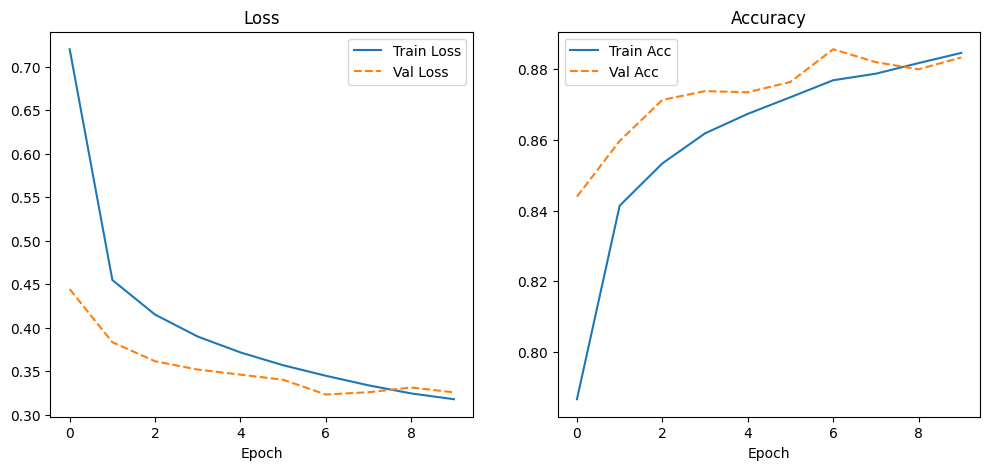

Dropout wynik: 87.63%
Epoka 1/10 (LR: 0.01000) | Train Loss: 1.1707 Acc: 0.6731 | Val Loss: 0.7349 Acc: 0.7812
Epoka 2/10 (LR: 0.01000) | Train Loss: 0.7255 Acc: 0.7786 | Val Loss: 0.5572 Acc: 0.8219
Epoka 3/10 (LR: 0.01000) | Train Loss: 0.6144 Acc: 0.8055 | Val Loss: 0.4857 Acc: 0.8407
Epoka 4/10 (LR: 0.01000) | Train Loss: 0.5543 Acc: 0.8201 | Val Loss: 0.4493 Acc: 0.8478
Epoka 5/10 (LR: 0.01000) | Train Loss: 0.5201 Acc: 0.8272 | Val Loss: 0.4287 Acc: 0.8526
Epoka 6/10 (LR: 0.01000) | Train Loss: 0.5011 Acc: 0.8335 | Val Loss: 0.4164 Acc: 0.8576
Epoka 7/10 (LR: 0.01000) | Train Loss: 0.4795 Acc: 0.8392 | Val Loss: 0.4014 Acc: 0.8603
Epoka 8/10 (LR: 0.01000) | Train Loss: 0.4626 Acc: 0.8425 | Val Loss: 0.3911 Acc: 0.8645
Epoka 9/10 (LR: 0.01000) | Train Loss: 0.4497 Acc: 0.8465 | Val Loss: 0.3837 Acc: 0.8647
Epoka 10/10 (LR: 0.01000) | Train Loss: 0.4419 Acc: 0.8496 | Val Loss: 0.3757 Acc: 0.8679

Trening zakończony. Najlepszy model załadowany.


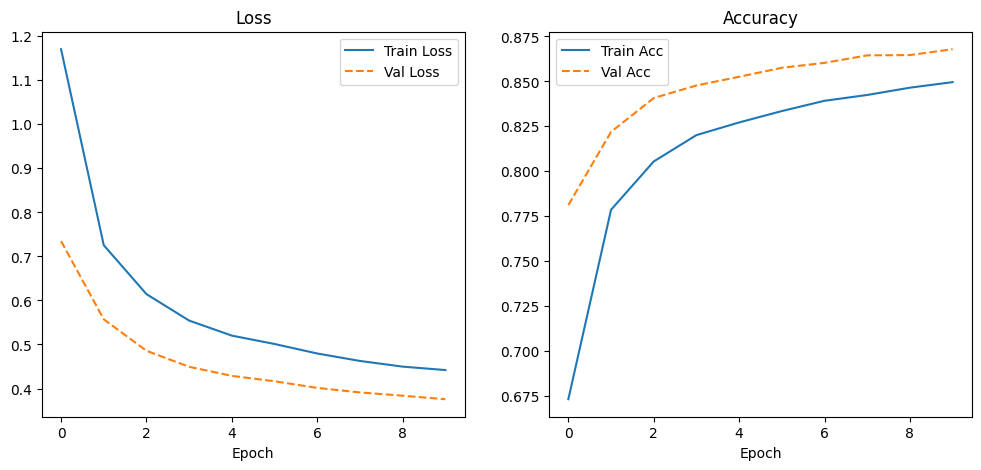

SGD wynik: 85.69%
Epoka 1/10 (LR: 0.00100) | Train Loss: 0.7083 Acc: 0.7831 | Val Loss: 0.4254 Acc: 0.8451
Epoka 2/10 (LR: 0.00100) | Train Loss: 0.4561 Acc: 0.8413 | Val Loss: 0.3947 Acc: 0.8575
Epoka 3/10 (LR: 0.00100) | Train Loss: 0.4132 Acc: 0.8543 | Val Loss: 0.3650 Acc: 0.8686
Epoka 4/10 (LR: 0.00100) | Train Loss: 0.3906 Acc: 0.8597 | Val Loss: 0.3499 Acc: 0.8718
Epoka 5/10 (LR: 0.00010) | Train Loss: 0.3663 Acc: 0.8706 | Val Loss: 0.3421 Acc: 0.8752
Epoka 6/10 (LR: 0.00010) | Train Loss: 0.3336 Acc: 0.8801 | Val Loss: 0.3225 Acc: 0.8832
Epoka 7/10 (LR: 0.00010) | Train Loss: 0.3226 Acc: 0.8840 | Val Loss: 0.3200 Acc: 0.8857
Epoka 8/10 (LR: 0.00010) | Train Loss: 0.3168 Acc: 0.8859 | Val Loss: 0.3176 Acc: 0.8833
Epoka 9/10 (LR: 0.00010) | Train Loss: 0.3173 Acc: 0.8864 | Val Loss: 0.3154 Acc: 0.8852
Epoka 10/10 (LR: 0.00001) | Train Loss: 0.3133 Acc: 0.8882 | Val Loss: 0.3144 Acc: 0.8840

Trening zakończony. Najlepszy model załadowany.


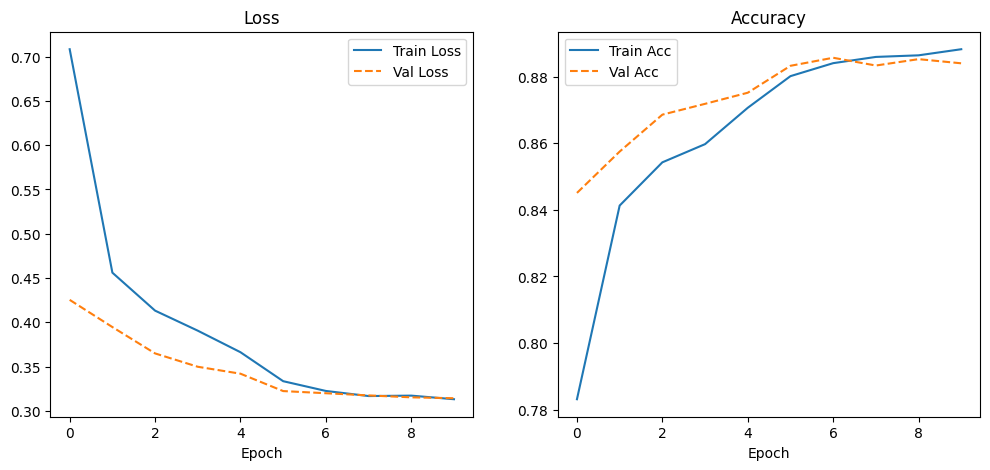

Scheduler_Adam wynik: 88.02%
0_BezEarlyStopping: 88.34%
earlyStopping: 87.63%
MalaArchitektura: 87.51%
DuzaArchitektura: 87.85%
RegularizacjaL2: 88.09%
BatchNorm: 87.48%
Dropout: 87.63%
SGD: 85.69%
Scheduler_Adam: 88.02%


In [10]:
def run_experiment(
    hidden_sizes=[256, 128],
    dropout=0.0,
    batch_norm=True,
    optimizer_cls=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    scheduler_cls=None,
    scheduler_params={},
    patience=5,
    epochs=10,
    name="exp"
):

    model = ParameterizedMLP(
        input_size=28*28,
        hidden_sizes=hidden_sizes,
        output_size=10,
        use_batch_norm=batch_norm,
        dropout=dropout
    )

    optimizer = optimizer_cls(model.parameters(), **optimizer_params)

    scheduler = None
    if scheduler_cls:
        scheduler = scheduler_cls(optimizer, **scheduler_params)


    trainer = Trainer(model, optimizer, torch.nn.CrossEntropyLoss(), scheduler=scheduler, patience=patience)
    trainer.train(train_loader, val_loader, n_epochs=epochs, save_path=f"{name}.pth")
    trainer.plot_history()

    return trainer.evaluate_test(test_loader)

experiments_config = [


    #no early stopping
    {
        "name": "0_BezEarlyStopping",
        "hidden_sizes": [100, 50],
        "patience": 50, # Duża cierpliwość = brak early stoppingu
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },

    #early stopping
    # w reszcie juz bedzie ten early bo inaczej 5 lat sie bedzie  robic
    {
        "name": "earlyStopping",
        "hidden_sizes": [100, 50],
        "patience": 5,  # zmiana
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },


    # mniejsza architektura
    {
        "name": "MalaArchitektura",
        "hidden_sizes": [50, 25],#zmiana
        "patience": 5,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },
    # 4. większa architektura
    {
        "name": "DuzaArchitektura",
        "hidden_sizes": [100, 50, 25],#zmiana
        "patience": 5,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },



    # 5. L2
    {
        "name": "RegularizacjaL2",
        "hidden_sizes": [100, 50],
        "patience": 5,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001, 'weight_decay': 0.0001} # dodajemy l2
    },


    # 6. batch normalization
    {
        "name": "BatchNorm",
        "hidden_sizes": [100, 50],
        "patience": 5,
        "batch_norm": False,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },


    # 7. dropout
    {
        "name": "Dropout",
        "hidden_sizes": [100, 50],
        "patience": 5,
        "dropout": 0.25,      # 25% neuronów wył dropoutem
        "batch_norm": True,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001}
    },


    # 8. optymalizator SGD
    {
        "name": "SGD",
        "hidden_sizes": [100, 50],
        "patience": 5,
        "dropout": 0.25,
        "batch_norm": True,
        "optimizer_cls": optim.SGD,   # zmiana na sgd
        "optimizer_params": {'lr': 0.01} # zmiana lr
    },


    # 9. scheduler zmienne LR
    {
        "name": "Scheduler_Adam",
        "hidden_sizes": [100, 50],
        "patience": 5,
        "dropout": 0.25,
        "batch_norm": True,
        "optimizer_cls": optim.Adam,
        "optimizer_params": {'lr': 0.001},
        "scheduler_cls": optim.lr_scheduler.StepLR, # scheduler
        "scheduler_params": {'step_size': 5, 'gamma': 0.1}
    }
]


results = {}

for config in experiments_config:

    acc = run_experiment(**config, epochs=10)
    results[config['name']] = acc
    print(f"{config['name']} wynik: {acc*100:.2f}%")

for name, acc in results.items():
    print(f"{name}: {acc*100:.2f}%")


#Wnioski


1. moze wygldac ze early stopping nie zadzialal ale sprawdzalam n awiekszej ilosci opok i wlasnie dociągał 10+ bo mialam wczesniej ustawiono więcej ale za długo to się robiło i nie chce uruchamiac jesczeraz 😢
2. Na podsumowaniu wyników widać dlaczego np korzysta się z Adama( o wielie ladniejsze te wykresy i wynik lepszy tez),
3. większa architektura niby radzi sobie liepeij ale jednak ma wieksze przeuczanie sie i linie testu i trainu zbyt od siebie oddalaja, wiec w tym akurat wypadku to raczej przekombinowanie.
4. Batch norm też pokazał troche lepszy wyniki na wykresie niż podstawowy model, jak i dropout - widać ze liepiej radza siebie z przeuczaniem sie.
5. Ale tak ogólnie widać ze model się przeucza bez dobrych usrawien no i że raczejj dla takich zadan liepiej brać jednak nie MLP